In [1]:
%matplotlib inline
import numpy as np
from scipy.misc import imread
import pickle
import matplotlib.pyplot as plt
from scipy.misc import imread
import tensorflow as tf
from keras.preprocessing import image
from keras.backend.tensorflow_backend import set_session
from ssd import SSD300
from keras.applications.imagenet_utils import preprocess_input
from ssd_utils import BBoxUtility

np.set_printoptions(suppress=True)
config = tf.ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.45
set_session(tf.Session(config=config))

Using TensorFlow backend.


In [2]:
NYU_CLASSES = ['bed', 'shelf', 'computer', 'plate', 'lamp',
              'table',
               'sofa', 'chair', 'person']
NUM_CLASSES = len(NYU_CLASSES) + 1
input_shape = (300, 300, 3) #channel last

In [3]:
model = SSD300(input_shape, num_classes=NUM_CLASSES)
model.load_weights('../checkpoints/SUNRGBD/weights.based_set_trainable_vgg16.hdf5')

(64,)


In [4]:
gt = pickle.load(open('../pkls/SUNRGBD/RGB.pkl', 'rb'))
keys = sorted(gt.keys())
num_train = int(round(0.8 * len(keys)))
train_keys = keys[:num_train]
val_keys = keys[num_train:]
num_val = len(val_keys)

In [16]:
path_prefix = '../dataset/'
inputs = []
images = []
img_path = path_prefix + sorted(val_keys )[10]
img = image.load_img(img_path, target_size=(300, 300))
img = image.img_to_array(img)
images.append(imread(img_path))
inputs.append(img.copy())
inputs = preprocess_input(np.array(inputs))

# img_path = path_prefix + sorted(keys)[3]
# img = image.load_img(img_path)
# img = image.img_to_array(img)

In [17]:
priors = pickle.load(open('../pkls/prior_boxes_ssd300.pkl', 'rb'))
bbox_util = BBoxUtility(NUM_CLASSES, priors)
preds = model.predict(inputs, batch_size=1, verbose=1)
results = bbox_util.detection_out(preds)

1/1 [==============================] - 0s


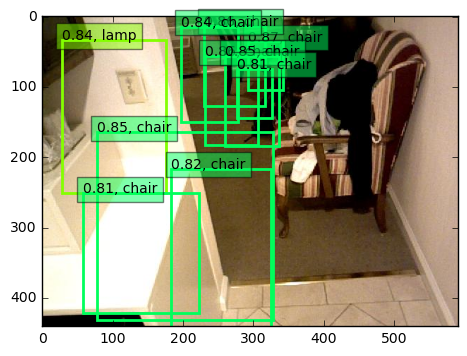

In [19]:
for i, img in enumerate(images):
    det_label = results[i][:, 0]
    det_conf = results[i][:, 1]
    det_xmin = results[i][:, 2]
    det_ymin = results[i][:, 3]
    det_xmax = results[i][:, 4]
    det_ymax = results[i][:, 5]

    # Get detections with confidence higher than 0.6.
    top_indices = [i for i, conf in enumerate(det_conf) if conf >= 0.8]

    top_conf = det_conf[top_indices]
    top_label_indices = det_label[top_indices].tolist()
    top_xmin = det_xmin[top_indices]
    top_ymin = det_ymin[top_indices]
    top_xmax = det_xmax[top_indices]
    top_ymax = det_ymax[top_indices]

    colors = plt.cm.hsv(np.linspace(0, 1, 21)).tolist()
    plt.imshow(img / 255.)
    currentAxis = plt.gca()


    for i in range(top_conf.shape[0]):
        xmin = int(round(top_xmin[i] * img.shape[1]))
        ymin = int(round(top_ymin[i] * img.shape[0]))
        xmax = int(round(top_xmax[i] * img.shape[1]))
        ymax = int(round(top_ymax[i] * img.shape[0]))
        score = top_conf[i]
        label = int(top_label_indices[i])
        label_name = NYU_CLASSES[label - 1]
        display_txt = '{:0.2f}, {}'.format(score, label_name)
        coords = (xmin, ymin), xmax-xmin, ymax-ymin
        color = colors[label]
        currentAxis.add_patch(plt.Rectangle(*coords, fill=False, edgecolor=color, linewidth=2))
        currentAxis.text(xmin, ymin, display_txt, bbox={'facecolor':color, 'alpha':0.5})
    
    plt.show()

In [35]:
# colors = plt.cm.hsv(np.linspace(0, 1, 21)).tolist()
# currentAxis = plt.gca()
# plt.imshow(img / 255.)
# xmin = int(round(array[0])) 
# ymin = int(round(array[1]))
# xmax = int(round(array[2])) + xmin
# ymax = int(round(array[3])) + ymin
# coords = (xmin, ymin), xmax - xmin +1, ymax - ymin+1
# color = colors[1]
# currentAxis.add_patch(plt.Rectangle(*coords, fill=False, edgecolor=color, linewidth=2))
# currentAxis.text(xmin, ymin, 'hello', bbox={'facecolor':color, 'alpha':0.5})
# plt.show()